In [2]:
import os
import cv2
import glob
import math
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from multiprocessing import Pool, cpu_count
from PIL import ImageFilter, ImageStat, Image, ImageDraw
from IPython.display import display
import keras

Using TensorFlow backend.


In [3]:
def show(X):
    display(Image.fromarray(X))

In [4]:
def im_multi(path):
    try:
        #print(path)
        im_stats_im_ = cv2.imread(path)
        #print(im_stats_im_.size)
        return [path, {'size': im_stats_im_.size}]
    except:
        print("Error path:%s"%(path))
        return [path, {'size': [0, 0]}]
    
def im_stats(im_stats_df):
    im_stats_d = {}
    p = Pool(cpu_count())
    ret = p.map(im_multi, im_stats_df['path'])
    for i in range(len(ret)):
        im_stats_d[ret[i][0]] = ret[i][1]
    im_stats_df['size'] = im_stats_df['path'].map(lambda x: ' '.join([str(s) for s in str(im_stats_d[x]['size'])]))
    return im_stats_df

In [8]:
all_cervix_images = []

basepath = '/home/dataset/train/'
for path in sorted(glob.glob(basepath + "*")):
    #print(path)
    cervix_type = path.split("/")[-1]
    #print(cervix_type)
    cervix_images = sorted(glob.glob(basepath + cervix_type + "/*"))
    #print(cervix_images)
    all_cervix_images = all_cervix_images + cervix_images

basepath = '/home/dataset/Type_'
for path in sorted(glob.glob(basepath + "*")):
    #print(path)
    cervix_type = path.split("/")[-1][-1]
    #print(cervix_type)
    cervix_images = sorted(glob.glob(basepath + cervix_type + "/*"))
    #print(cervix_images)
    all_cervix_images = all_cervix_images + cervix_images

In [9]:
all_cervix_images = pd.DataFrame({'imagepath': all_cervix_images})
all_cervix_images['filetype'] = all_cervix_images.apply(lambda row: row.imagepath.split(".")[-1], axis=1)
all_cervix_images['type'] = all_cervix_images.apply(lambda row: row.imagepath.split("/")[-2], axis=1)
all_cervix_images.head()

,imagepath,filetype,type
0,/home/dataset/train/Type_1/0.jpg,jpg,Type_1
1,/home/dataset/train/Type_1/10.jpg,jpg,Type_1
2,/home/dataset/train/Type_1/1013.jpg,jpg,Type_1
3,/home/dataset/train/Type_1/1014.jpg,jpg,Type_1
4,/home/dataset/train/Type_1/1019.jpg,jpg,Type_1


In [10]:
test = glob.glob('/home/dataset/test_stg2/*.jpg')
test = pd.DataFrame([[p.split('/')[4],p] for p in test], columns = ['image','path'])

test_id = test.image.values
test.head()

,image,path
0,12708.jpg,/home/dataset/test_stg2/12708.jpg
1,13284.jpg,/home/dataset/test_stg2/13284.jpg
2,11551.jpg,/home/dataset/test_stg2/11551.jpg
3,11151.jpg,/home/dataset/test_stg2/11151.jpg
4,11643.jpg,/home/dataset/test_stg2/11643.jpg


In [11]:
test.shape

(3506, 2)

In [12]:
test_ = im_stats(test)

In [13]:
test_1 = test_[test_['size'] != '[ 0 ,   0 ]'].reset_index(drop=True)    #remove bad images

In [14]:
test_1.shape

(3506, 3)

In [17]:
#test_1.to_csv("TEST_STG2.csv",index=False)

In [18]:
#test_1 = pd.read_csv("TEST_STG2.csv")

In [17]:
test_1.head()

,image,path,size
0,12708.jpg,/home/dataset/test_stg2/12708.jpg,2 3 9 7 0 8 1 6
1,13284.jpg,/home/dataset/test_stg2/13284.jpg,2 3 9 7 0 8 1 6
2,11551.jpg,/home/dataset/test_stg2/11551.jpg,2 3 9 7 0 8 1 6
3,11151.jpg,/home/dataset/test_stg2/11151.jpg,2 3 9 7 0 8 1 6
4,11643.jpg,/home/dataset/test_stg2/11643.jpg,2 3 9 7 0 8 1 6


In [18]:
def maxRect(img):
    maxArea = (0, 0, 0)
    addMat = np.zeros(img.shape)
    for r in range(img.shape[0]):
        if r == 0:
            addMat[r] = img[r]
            area = maxHist(addMat[r])
            if area[0] > maxArea[0]:
                maxArea = area + (r,)
        else:
            addMat[r] = img[r] + addMat[r-1]
            addMat[r][img[r] == 0] *= 0
            area = maxHist(addMat[r])
            if area[0] > maxArea[0]:
                maxArea = area + (r,)
    return (int(maxArea[3] + 1 - (maxArea[0]/abs(maxArea[1] - maxArea[2])/255.)),\
            maxArea[2], maxArea[3], maxArea[1], maxArea[0])

In [19]:
def maxHist(hist):
    maxArea = (0, 0, 0)
    height = [] # 尋找  Rectangle 的高度
    position = []
    #print(len(hist))
    
    for i in range(len(hist)):
        
        #print(len(height), hist[i], height)
        
        if (len(height) == 0):
            if (hist[i] > 0):
                
                height.append(hist[i])
                position.append(i)
        else: 
            #print(i, height, hist[i] , position)
            #print(hist[i] > height[-1], hist[i] < height[-1])
            
            if (hist[i] > height[-1]):
                # 高度增加
                height.append(hist[i])
                position.append(i)
                
            elif (hist[i] < height[-1]):
                # 高度降低
                while (height[-1] > hist[i]):
                    
                    maxHeight = height.pop() # 把最後一個高度取出來
                    #print(maxHeight)
                    area = maxHeight * (i - position[-1]) # 計算面積
                    
                    if (area > maxArea[0]):
                        maxArea = (area, position[-1], i)
                    last_position = position.pop() # 把前面高度上升時的位置記錄下來
                    
                    if (len(height) == 0): 
                        break
                        
                position.append(last_position)
                
                if (len(height) == 0):
                    height.append(hist[i])
                elif(height[-1] < hist[i]):
                    height.append(hist[i])
                else:
                    position.pop()   
                    
    while (len(height) > 0):
        
        maxHeight = height.pop()
        last_position = position.pop()
        area =  maxHeight * (len(hist) - last_position)
        if (area > maxArea[0]):
            maxArea = (area, len(hist), last_position)
            
    return maxArea    

In [63]:
def cropCircle(img, resize):
    
    if(img.shape[0] > img.shape[1]):
        tile_size = (2*int(img.shape[1]*256/img.shape[0]), 2*256)
    else:
        tile_size = (2*256, 2*int(img.shape[0]*256/img.shape[1]))
    
    img = cv2.resize(img, dsize = tile_size)
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    try:
        _, thresh = cv2.threshold(gray, 120, 255, cv2.THRESH_BINARY) # 可調整截取強度，數字越大越強

        #http://monkeycoding.com/?p=615
        im2, contours, hierarchy = cv2.findContours(thresh.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
        main_contour = sorted(contours, key = cv2.contourArea, reverse = True)[0] 
        ff = np.zeros((gray.shape[0], gray.shape[1]), 'uint8') 
        cv2.drawContours(ff, main_contour, -1, (255, 255, 255), 3)

        # http://docs.opencv.org/2.4/modules/imgproc/doc/miscellaneous_transformations.html
        ff_mask = np.zeros((gray.shape[0] + 2, gray.shape[1] + 2), 'uint8')
        cv2.floodFill(ff, ff_mask, (int(gray.shape[1]/2), int(gray.shape[0]/2)), 200)

        rect = maxRect(ff)
        rectangle = [min(rect[0], rect[2]), max(rect[0], rect[2]),\
                     min(rect[1], rect[3]), max(rect[1], rect[3])]
        img_crop = img[rectangle[0]:rectangle[1], rectangle[2]:rectangle[3]]
        cv2.rectangle(ff,(min(rect[1],rect[3]),min(rect[0],rect[2])),(max(rect[1],rect[3]),max(rect[0],rect[2])),3,2)

        img_ = cv2.rectangle(img, (min(rect[1],rect[3]),
                                 min(rect[0],rect[2])),
                            (max(rect[1],rect[3]),
                             max(rect[0],rect[2])), 255, 2)
        
        img_nocrop_r =  cv2.resize(img_, dsize = (resize, resize))
        img_crop_r =  cv2.resize(img_crop, dsize = (resize, resize))
        
    except:
        
        img_nocrop_r =  cv2.resize(img, dsize = (resize, resize))
        img_crop_r =  cv2.resize(img, dsize = (resize, resize))
        
    return img_crop_r, img_nocrop_r #, rectangle, tile_size]

In [21]:
def get_im_cv2(args):
    
    img = cv2.imread(args[0])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    crop_resized, nocrop_resized = cropCircle(img, args[1])
    
    return [args[0], crop_resized, nocrop_resized]

In [22]:
def image_features(paths, dim):
    
    imf_d1 = {}
    imf_d2 = {}
    p = Pool(cpu_count())
    dims = [dim for i in range(len(paths.tolist()))]
    params = list(zip(paths.tolist(), dims))
    ret = p.map(get_im_cv2, params)
    #print(ret)
    
    for i in range(len(ret)):
        imf_d1[ret[i][0]] = ret[i][1]
        
    for i in range(len(ret)):
        imf_d2[ret[i][0]] = ret[i][2]
        
    ret = []
    fdata1 = [imf_d1[f] for f in paths]
    fdata1 = np.array(fdata1, dtype = np.uint8)
    
    fdata2 = [imf_d2[f] for f in paths]
    fdata2 = np.array(fdata2, dtype = np.uint8)
    
    return fdata1, fdata2

In [64]:
dim = 192
test_data1, test_data2 = image_features(test_1['path'], dim)

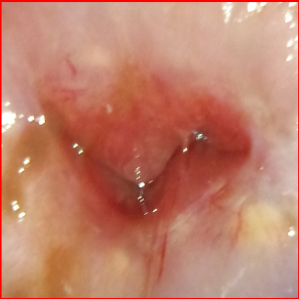

In [65]:
show(test_data1[600])

In [68]:
%timeit np.save('ALL_TEST_STG2_SEGPA_120_192.npy', test_data1)

1 loop, best of 3: 7.01 s per loop


In [69]:
%timeit np.save('ALL_TEST_STG2_NOSEGPA_120_192.npy', test_data2)

1 loop, best of 3: 7.03 s per loop


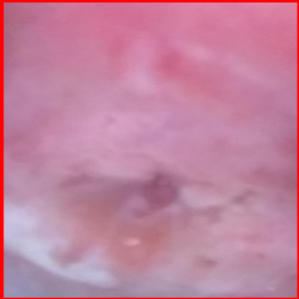

In [66]:
show(test_data1[2500])

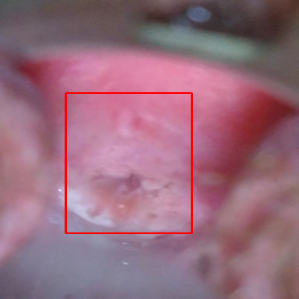

In [67]:
show(test_data2[2500])